In [599]:
import seaborn as sns
import sdeint
import matplotlib.pyplot as plt
import pandas as pd
import sympy as smp
import numpy as np
import pycatch22 as catch22
import pickle
from time import perf_counter
from sympy import real_roots
import statistics
import scipy.stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer, FunctionTransformer
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform, cdist
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.optimize import fsolve

In [274]:
from matplotlib.colors import LinearSegmentedColormap

cm_data = [[0.2081, 0.1663, 0.5292], [0.2116238095, 0.1897809524, 0.5776761905], 
 [0.212252381, 0.2137714286, 0.6269714286], [0.2081, 0.2386, 0.6770857143], 
 [0.1959047619, 0.2644571429, 0.7279], [0.1707285714, 0.2919380952, 
  0.779247619], [0.1252714286, 0.3242428571, 0.8302714286], 
 [0.0591333333, 0.3598333333, 0.8683333333], [0.0116952381, 0.3875095238, 
  0.8819571429], [0.0059571429, 0.4086142857, 0.8828428571], 
 [0.0165142857, 0.4266, 0.8786333333], [0.032852381, 0.4430428571, 
  0.8719571429], [0.0498142857, 0.4585714286, 0.8640571429], 
 [0.0629333333, 0.4736904762, 0.8554380952], [0.0722666667, 0.4886666667, 
  0.8467], [0.0779428571, 0.5039857143, 0.8383714286], 
 [0.079347619, 0.5200238095, 0.8311809524], [0.0749428571, 0.5375428571, 
  0.8262714286], [0.0640571429, 0.5569857143, 0.8239571429], 
 [0.0487714286, 0.5772238095, 0.8228285714], [0.0343428571, 0.5965809524, 
  0.819852381], [0.0265, 0.6137, 0.8135], [0.0238904762, 0.6286619048, 
  0.8037619048], [0.0230904762, 0.6417857143, 0.7912666667], 
 [0.0227714286, 0.6534857143, 0.7767571429], [0.0266619048, 0.6641952381, 
  0.7607190476], [0.0383714286, 0.6742714286, 0.743552381], 
 [0.0589714286, 0.6837571429, 0.7253857143], 
 [0.0843, 0.6928333333, 0.7061666667], [0.1132952381, 0.7015, 0.6858571429], 
 [0.1452714286, 0.7097571429, 0.6646285714], [0.1801333333, 0.7176571429, 
  0.6424333333], [0.2178285714, 0.7250428571, 0.6192619048], 
 [0.2586428571, 0.7317142857, 0.5954285714], [0.3021714286, 0.7376047619, 
  0.5711857143], [0.3481666667, 0.7424333333, 0.5472666667], 
 [0.3952571429, 0.7459, 0.5244428571], [0.4420095238, 0.7480809524, 
  0.5033142857], [0.4871238095, 0.7490619048, 0.4839761905], 
 [0.5300285714, 0.7491142857, 0.4661142857], [0.5708571429, 0.7485190476, 
  0.4493904762], [0.609852381, 0.7473142857, 0.4336857143], 
 [0.6473, 0.7456, 0.4188], [0.6834190476, 0.7434761905, 0.4044333333], 
 [0.7184095238, 0.7411333333, 0.3904761905], 
 [0.7524857143, 0.7384, 0.3768142857], [0.7858428571, 0.7355666667, 
  0.3632714286], [0.8185047619, 0.7327333333, 0.3497904762], 
 [0.8506571429, 0.7299, 0.3360285714], [0.8824333333, 0.7274333333, 0.3217], 
 [0.9139333333, 0.7257857143, 0.3062761905], [0.9449571429, 0.7261142857, 
  0.2886428571], [0.9738952381, 0.7313952381, 0.266647619], 
 [0.9937714286, 0.7454571429, 0.240347619], [0.9990428571, 0.7653142857, 
  0.2164142857], [0.9955333333, 0.7860571429, 0.196652381], 
 [0.988, 0.8066, 0.1793666667], [0.9788571429, 0.8271428571, 0.1633142857], 
 [0.9697, 0.8481380952, 0.147452381], [0.9625857143, 0.8705142857, 0.1309], 
 [0.9588714286, 0.8949, 0.1132428571], [0.9598238095, 0.9218333333, 
  0.0948380952], [0.9661, 0.9514428571, 0.0755333333], 
 [0.9763, 0.9831, 0.0538]]

parula_map = LinearSegmentedColormap.from_list('parula', cm_data)

# Chapter 2: Naive Instance Space

## 1.1 Toy Systems

### 1.1.1 Trivial Case: Low (fixed) noise $\eta$ and Fixed Length $N=5000$

Generate 100 samples from each toy system with fixed noise $\eta = 0.01$ and length N = 5000. Control parameter $\mu$ is randomly sampled with arbitrary bounds.

In [19]:
def gen_hopf(num_samples): # num samples, N=length
    # hopf
    eta_val_hopf = np.tile(0.01, num_samples)
    mu_val_hopf = np.random.uniform(-5, 5, size=num_samples)
    sols_list = list()
    dt = 0.01
    tspan = np.arange(0, 55, dt)
    print('Generating Hopf Instances...')
    t_start = perf_counter()
    for i in range(num_samples):
        mu = mu_val_hopf[i]
        eta = eta_val_hopf[i]
        def f(state, t):
            x, y = state[0], state[1]
            dxdt = -y + (mu - x**2 - y**2) * x
            dydt = x + (mu - x **2 - y **2) * y
            return dxdt, dydt
        ic = np.array(np.random.uniform(size=2))
        gw = lambda y, t: eta * np.identity(ic.shape[0])
        fw = lambda y, t: np.array(f(y,t))
        sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
        sols_list.append(sol[500:]) # remove transient
    ts_hopf = np.array([sols_list[i][:,0] for i in range(len(sols_list))])
    features_hopf = np.array([catch22.catch22_all(ts_hopf[i,:])['values'] for i in range(len(ts_hopf))])
    df = pd.DataFrame(features_hopf)
    df['mu'] = mu_val_hopf
    df['eta'] = eta_val_hopf
    df['regime'] = 'Hopf'
    t_end = perf_counter()
    print(f'Time Elapsed: {t_end-t_start:.2f}s')
    return ts_hopf, df

In [81]:
ts_hopf, df_hopf = gen_hopf(100)

Generating Limit Cycle Instances...
Time Elapsed: 27.83s


In [559]:
def gen_hookes(num_samples):
    #system 1 - hookes
    eta_val_hookes = np.tile(0.01, num_samples)
    mu_val_hookes = np.random.uniform(-1.1, -0.98, size=num_samples)
    sols_list = list()
    dt = 0.01
    tspan = np.arange(0, 55, dt)
    print('Generating Hookes Instances...')
    for i in range(num_samples):
        mu = mu_val_hookes[i]
        eta = eta_val_hookes[i]
        def f(state, t):
            x = state[0]
            dxdt = mu *x
            return dxdt
        ic = np.array([np.random.uniform()])
        gw = lambda y, t: eta * np.identity(ic.shape[0])
        fw = lambda y, t: np.array(f(y,t))
        sol = sdeint.itoint(fw, gw, np.array([ic]), tspan)
        sols_list.append(sol[500:])
    ts_hookes = np.array([sols_list[i][:,0] for i in range(len(sols_list))])
    features_hookes = np.array([catch22.catch22_all(ts_hookes[i,:])['values'] for i in range(len(ts_hookes))])
    df_hookes = pd.DataFrame(features_hookes)
    df_hookes['mu'] = mu_val_hookes
    df_hookes['eta'] = eta_val_hookes
    df_hookes['regime'] = 'HookesFP'
    return ts_hookes, df_hookes

In [83]:
ts_hookes, df_hookes = gen_hookes(100)

Generating Hookes Instances...


In [124]:
def gen_bistable(num_samples):
    eta_val_bistable = np.tile(0.01, num_samples)
    mu_val_bistable = np.random.uniform(-5, 5, size=num_samples)
    sols_list = list()
    dt = 0.01
    tspan = np.arange(0, 55, dt)
    print('Generating Bistable Switching Instances...')
    for i in range(num_samples):
        mu = mu_val_bistable[i]
        eta = eta_val_bistable[i]
        def f(state, t):
            x = state
            dxdt = mu + x - x**3
            return dxdt
        ic = np.array([np.random.uniform()])
        gw = lambda y, t: eta * np.identity(ic.shape[0])
        fw = lambda y, t: np.array(f(y,t))
        sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
        sols_list.append(sol[500:])
    ts_bistable = np.array([sols_list[i][:,0] for i in range(len(sols_list))])
    features_bistable = np.array([catch22.catch22_all(ts_bistable[i,:])['values'] for i in range(len(ts_bistable))])
    df = pd.DataFrame(features_bistable)
    df['mu'] = mu_val_bistable
    df['eta'] = eta_val_bistable
    df['regime'] = 'Bistable'
    return ts_bistable, df

In [125]:
ts_bistable, df_bistable = gen_bistable(100)

Generating Bistable Switching Instances...


In [142]:
X = np.vstack([df_hopf.iloc[:,:22], df_hookes.iloc[:,:22], df_bistable.iloc[:,:22]])
y = np.concatenate([np.tile(0, len(df_hopf)), np.tile(1, len(df_hookes)), np.tile(2, len(df_bistable))])

Examine distribution of the raw outputs for each feature before scaling.

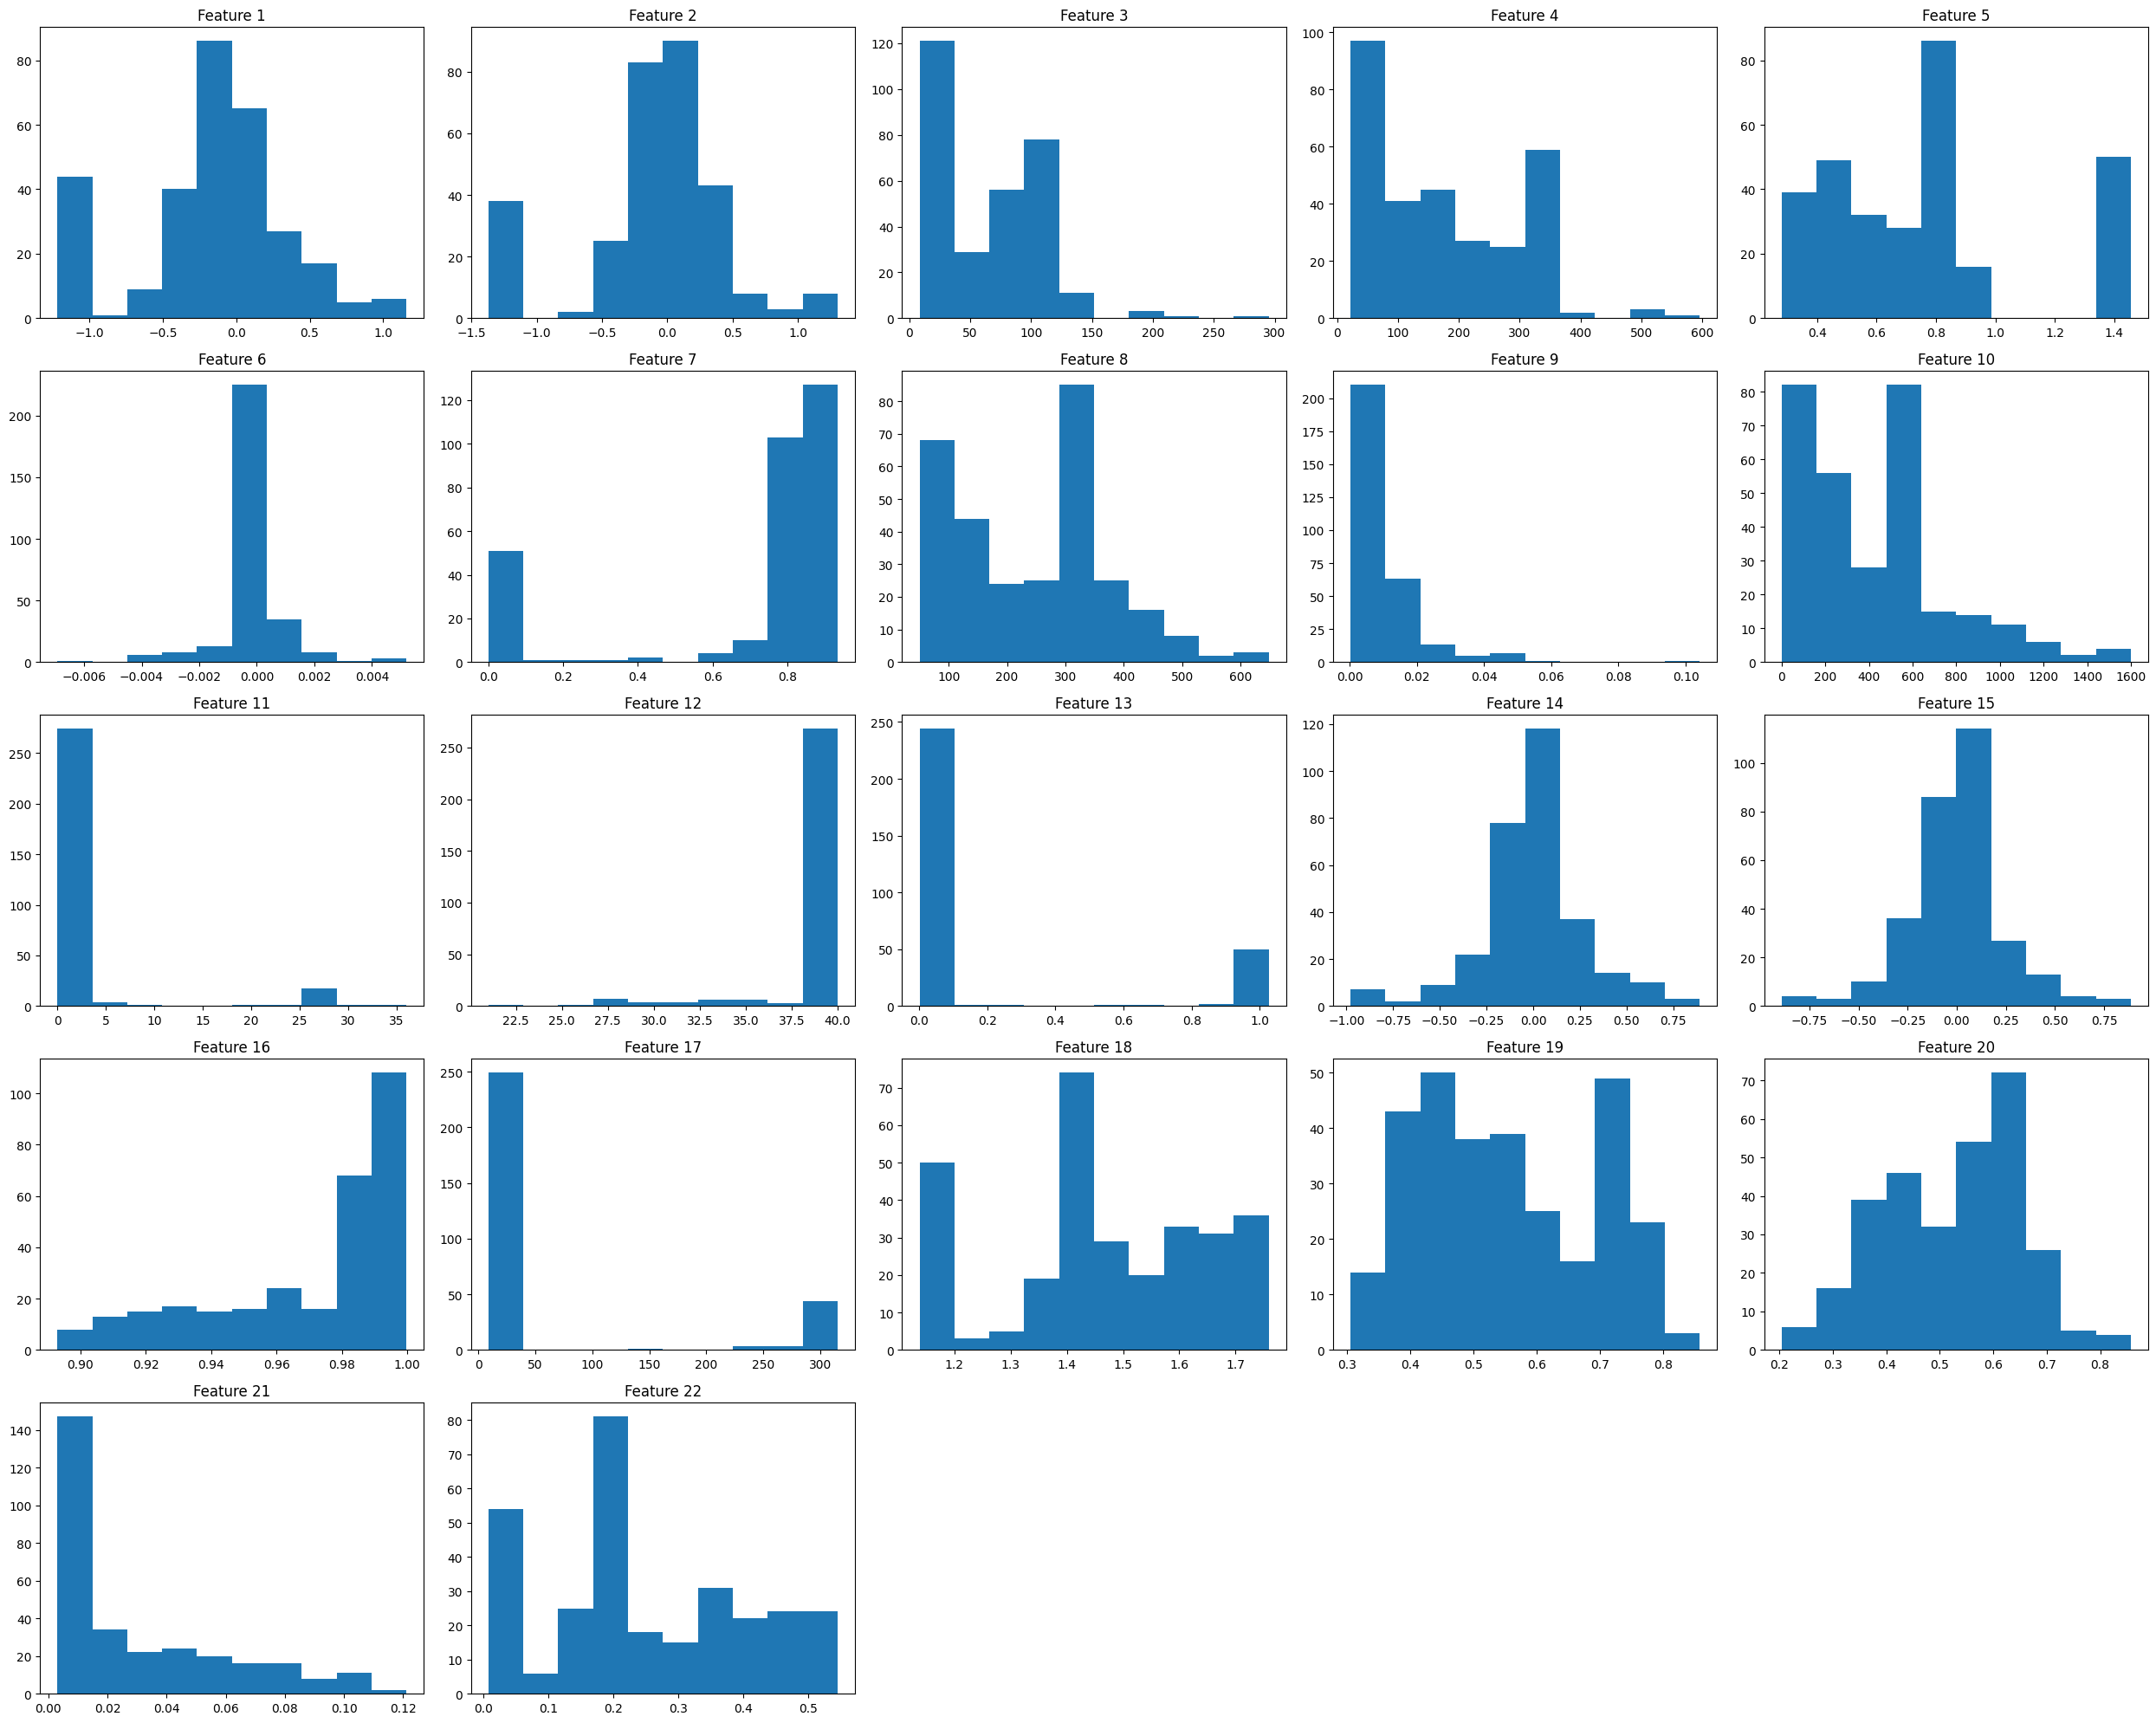

In [143]:
fig, axes = plt.subplots(5, 5, figsize=(25, 20))
for index, ax in enumerate(axes.ravel()):
    if index > 21:
        ax.axis('off')
    else:
        ax.hist(X[:,index])
        ax.set_title(f'Feature {index+1}')
fig.tight_layout()

Examine distributions of features after rescaling

In [152]:
rs = RobustScaler().fit(X)
rs_fit = rs.transform(X)
def sigmoid(x, theta):
    return 1/(1+np.exp(-theta*x))
sigmoid_transformer = FunctionTransformer(sigmoid, kw_args={'theta': 1.35})
sigmoid_transformer.fit(rs_fit)
sigmoid_fit = sigmoid_transformer.transform(rs_fit)
mm = MinMaxScaler().fit(sigmoid_fit)
X_hat = mm.transform(sigmoid_fit)

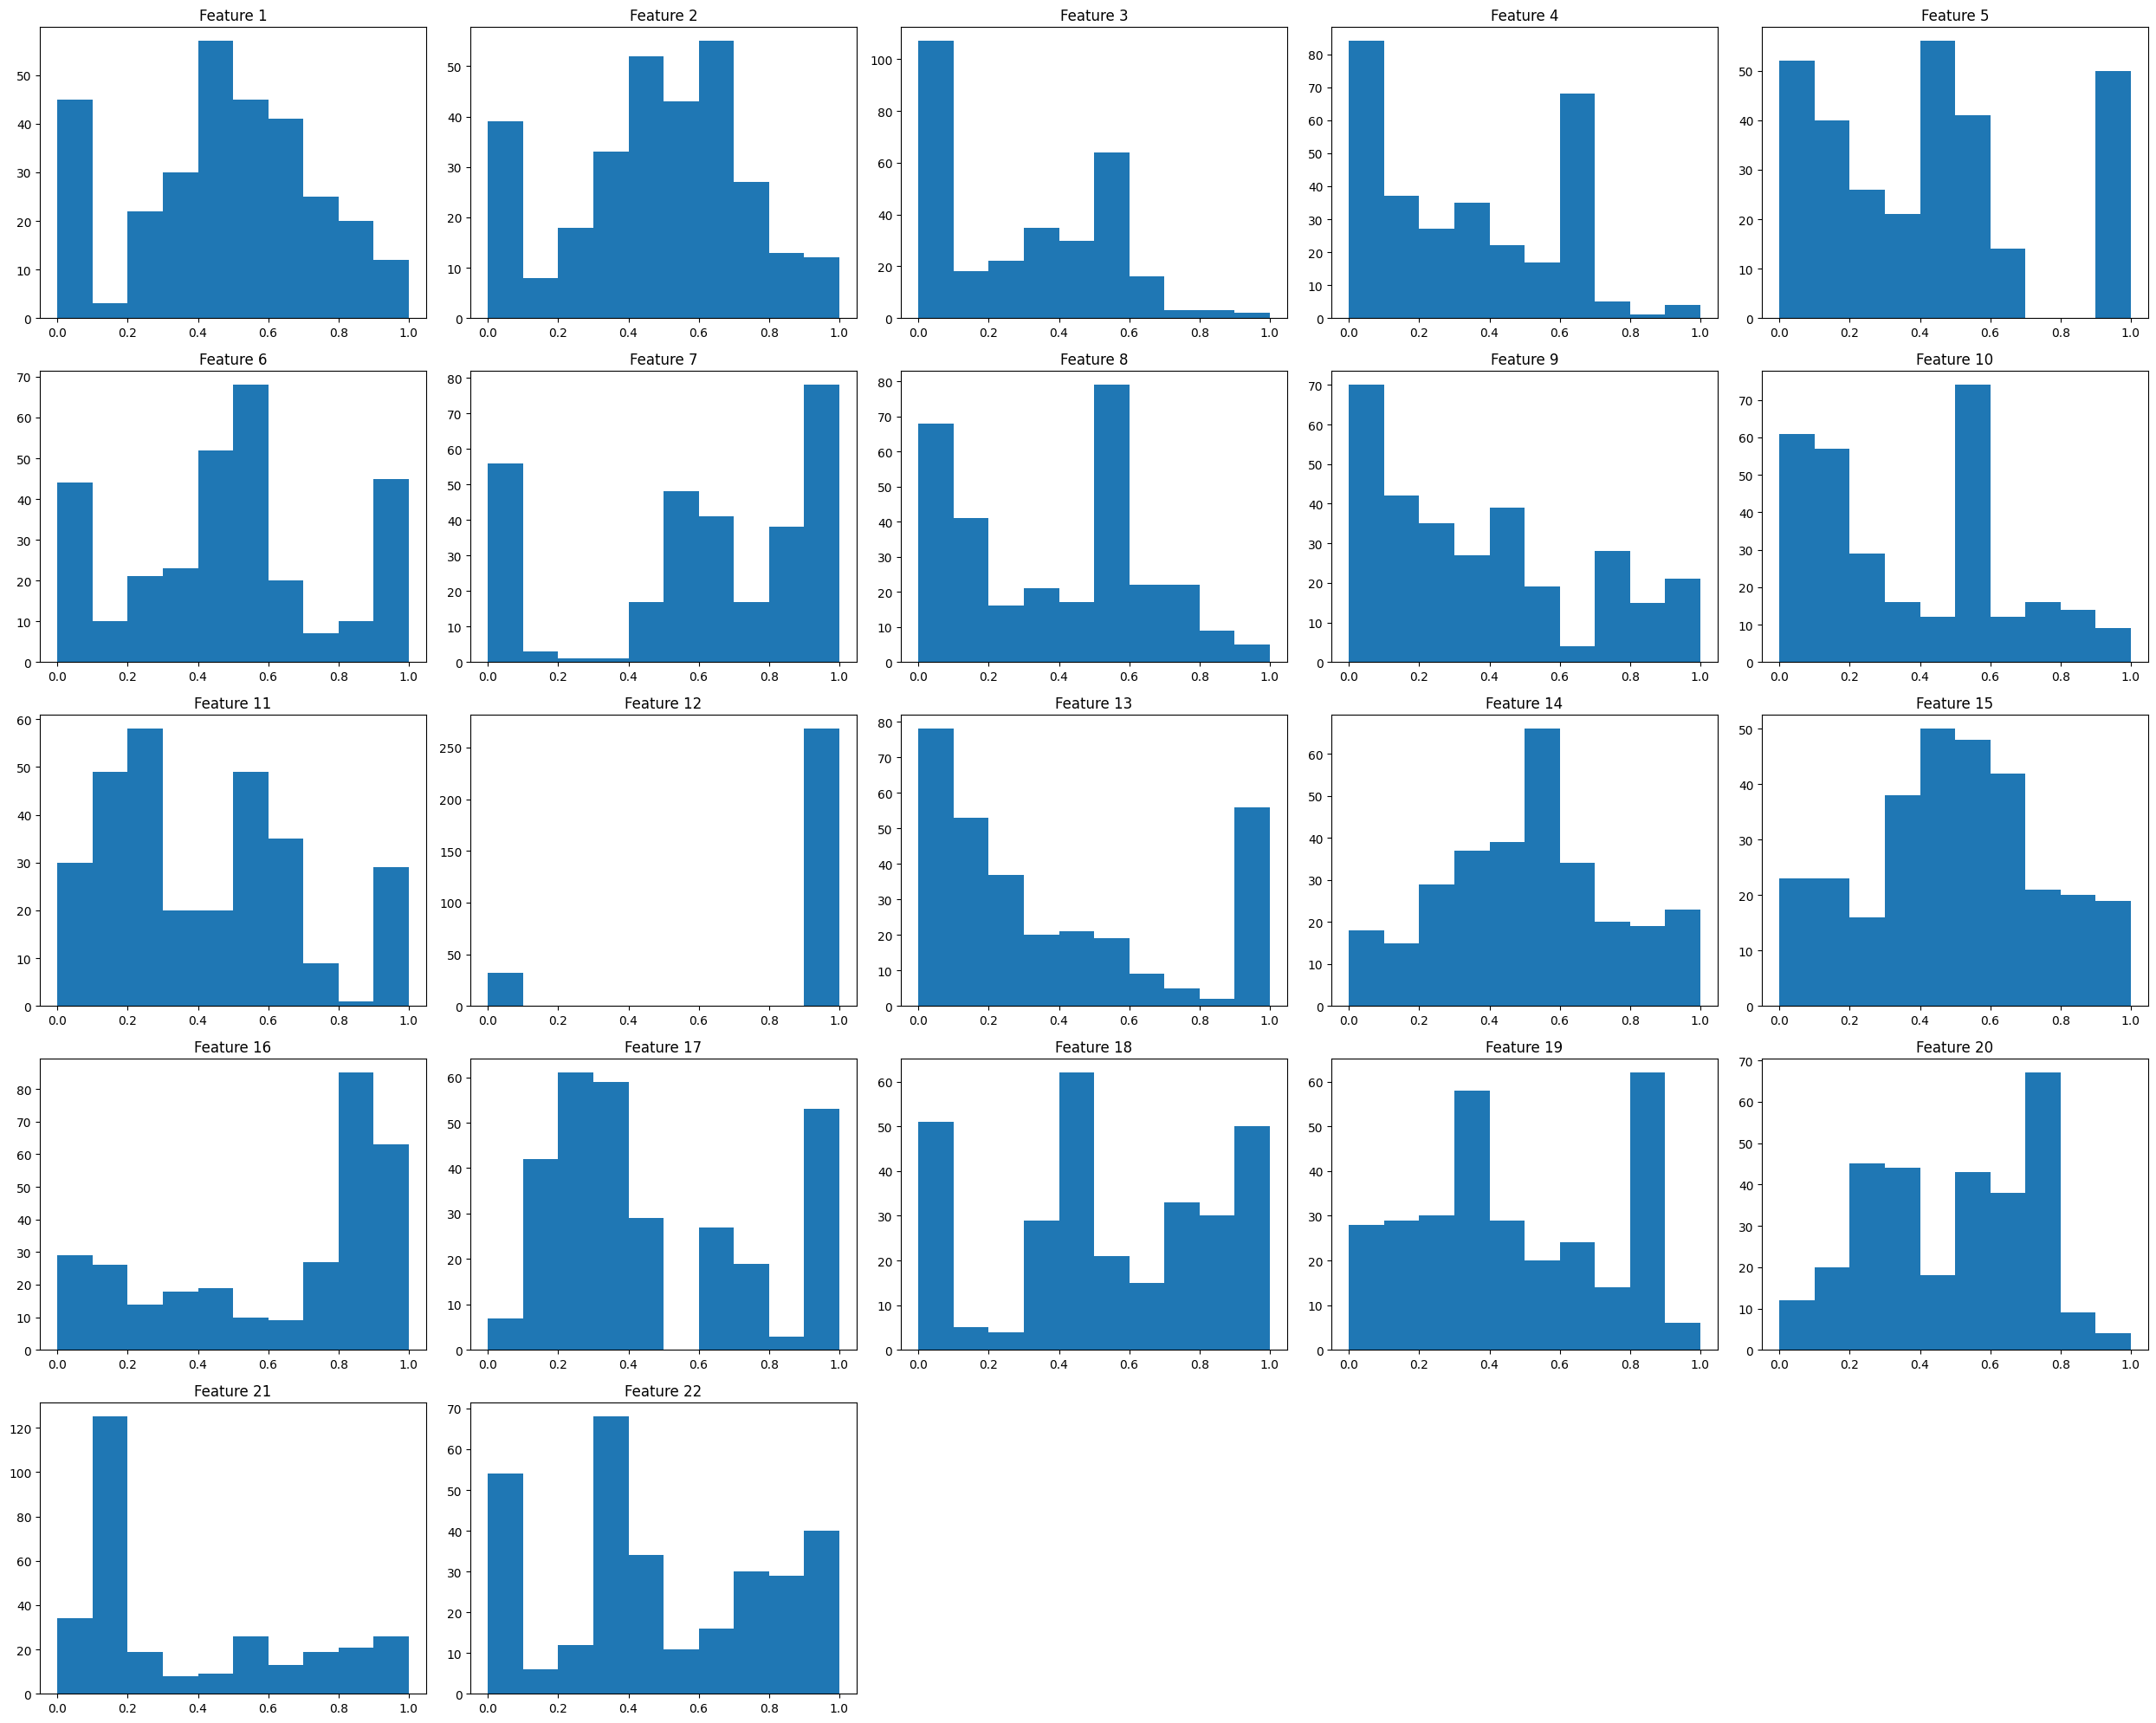

In [135]:
fig, axes = plt.subplots(5, 5, figsize=(25, 20))
for index, ax in enumerate(axes.ravel()):
    if index > 21:
        ax.axis('off')
    else:
        ax.hist(X_hat[:,index])
        ax.set_title(f'Feature {index+1}')
fig.tight_layout()

Project into instance space

In [153]:
pca_fit = PCA(n_components=2).fit(X_hat)
pca = pca_fit.transform(X_hat)

In [298]:
pca_hopf = pca[:len(df_hopf), :]
pca_hookes = pca[len(df_hopf):len(df_hopf)+len(df_hookes), :]
pca_bistable = pca[len(df_hopf)+len(df_hookes):, :]

In [318]:
lc_subset = df_hopf[df_hopf['mu'] > 0].index.to_numpy()
pca_hopf[lc_subset, 0].shape

(50,)

Examine Hopf Evolution for fixed eta

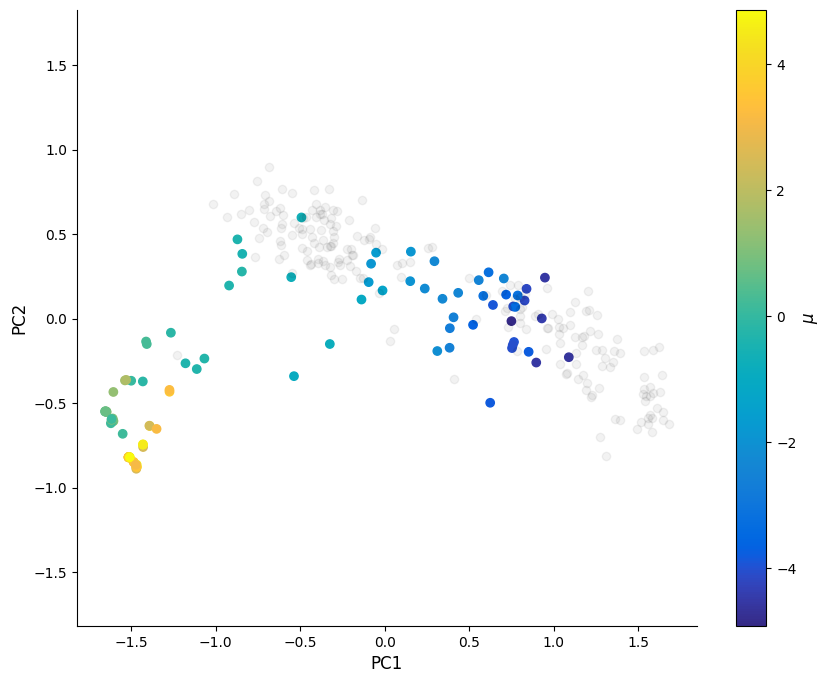

In [378]:
plt.figure(figsize=(10,8))
# separate into fp and limit cycle for hopf - o marker for fixed pt and x for limit cycle
lc_subset = df_hopf[df_hopf['mu'] > 0].index.to_numpy()
fp_subset = df_hopf[df_hopf['mu'] < 0].index.to_numpy()
plt.scatter(pca_hopf[:,0], pca_hopf[:,1], label='Hopf Limit Cycle', c=df_hopf['mu'], cmap=parula_map, marker='o')
cbar = plt.colorbar().set_label('$\mu$', fontsize=12)
# retain other pts in instance space for fixed axes
plt.scatter(pca_hookes[:,0], pca_hookes[:,1], c='k', label='Hookes', alpha=0.05)
plt.scatter(pca_bistable[:,0], pca_bistable[:,1], c='k', label='Bistable', alpha=0.05)
plt.xlabel('PC1', fontsize=12)
plt.ylabel('PC2', fontsize=12)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.axis('equal')
#plt.savefig('fixed_eta_hopf.svg')
plt.show()

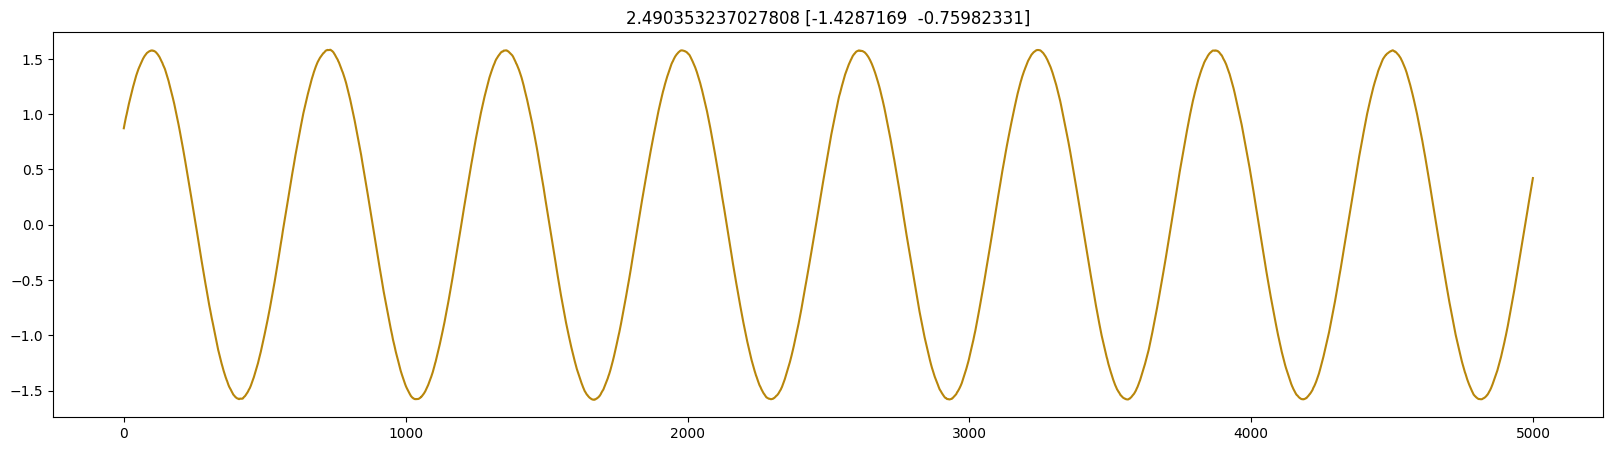

In [400]:
plt.figure(figsize=(20,5))
index = 3
plt.plot(ts_hopf[index], c='darkgoldenrod')
mu = str(df_hopf.iloc[index]['mu'])
string = mu + ' ' + str(pca_hopf[index])
plt.title(string)
#plt.savefig('Hopf_TS_exampleMuGreater0.svg')
plt.show()

Combined instance space

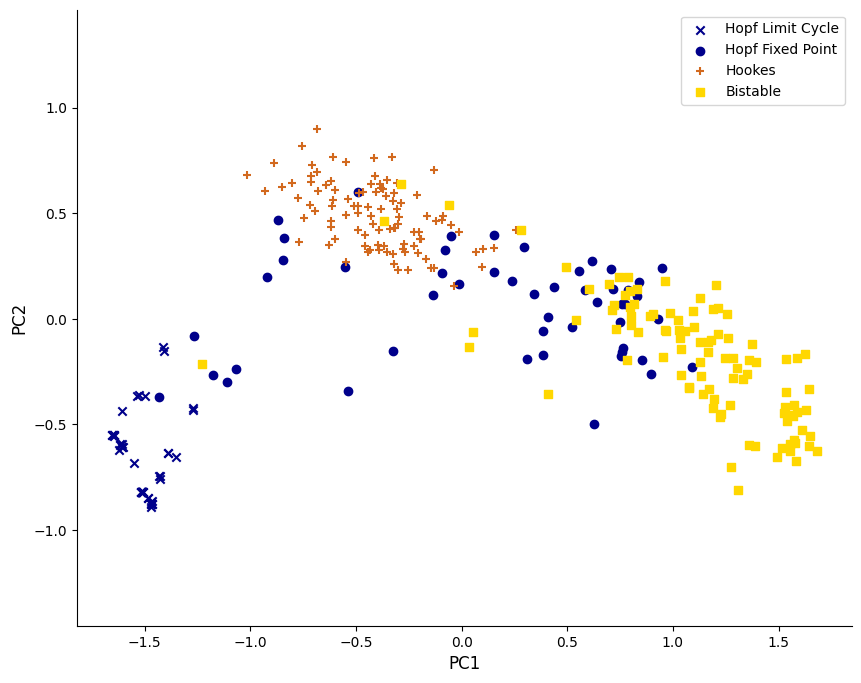

In [419]:
plt.figure(figsize=(10,8))
# separate into fp and limit cycle for hopf - o marker for fixed pt and x for limit cycle
lc_subset = df_hopf[df_hopf['mu'] > 0].index.to_numpy()
fp_subset = df_hopf[df_hopf['mu'] < 0].index.to_numpy()
plt.scatter(pca_hopf[lc_subset,0], pca_hopf[lc_subset,1], label='Hopf Limit Cycle', c='darkblue', marker='x')
plt.scatter(pca_hopf[fp_subset,0], pca_hopf[fp_subset,1], label='Hopf Fixed Point', c='darkblue', marker='o')
# retain other pts in instance space for fixed axes
plt.scatter(pca_hookes[:,0], pca_hookes[:,1], c='chocolate', label='Hookes', marker='+')
plt.scatter(pca_bistable[:,0], pca_bistable[:,1], c='gold', label='Bistable', marker='s')
plt.xlabel('PC1', fontsize=12)
plt.ylabel('PC2', fontsize=12)
plt.legend()
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.axis('equal')
#plt.savefig('fixed_eta_hopf.svg')
plt.show()

In [440]:
def gen_hopf(num_samples, N): # num samples, N=length
    # hopf
    eta_val_hopf = np.tile(0.01, num_samples)
    mu_val_hopf = np.tile(-1, num_samples)
    sols_list = list()
    dt = 0.01
    length = (N + 500) * dt
    tspan = np.arange(0, length, dt)
    print('Generating Hopf Instances...')
    t_start = perf_counter()
    for i in range(num_samples):
        mu = mu_val_hopf[i]
        eta = eta_val_hopf[i]
        def f(state, t):
            x, y = state[0], state[1]
            dxdt = -y + (mu - x**2 - y**2) * x
            dydt = x + (mu - x **2 - y **2) * y
            return dxdt, dydt
        ic = np.array(np.random.uniform(size=2))
        gw = lambda y, t: eta * np.identity(ic.shape[0])
        fw = lambda y, t: np.array(f(y,t))
        sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
        sols_list.append(sol[500:]) # remove transient
    ts_hopf = np.array([sols_list[i][:,0] for i in range(len(sols_list))])
    features_hopf = np.array([catch22.catch22_all(ts_hopf[i,:])['values'] for i in range(len(ts_hopf))])
    df = pd.DataFrame(features_hopf)
    df['mu'] = mu_val_hopf
    df['eta'] = eta_val_hopf
    df['regime'] = 'Hopf'
    t_end = perf_counter()
    print(f'Time Elapsed: {t_end-t_start:.2f}s')
    return ts_hopf, df

In [573]:
def gen_hookes(num_samples, N):
    #system 1 - hookes
    eta_val_hookes = np.tile(0.01, num_samples)
    mu_val_hookes = np.random.uniform(-1.1, size=num_samples)
    sols_list = list()
    dt = 0.01
    length = (N + 500) * dt
    tspan = np.arange(0, length, dt)
    print('Generating Hookes Instances...')
    for i in range(num_samples):
        mu = mu_val_hookes[i]
        eta = eta_val_hookes[i]
        def f(state, t):
            x = state[0]
            dxdt = mu *x
            return dxdt
        ic = np.array([np.random.uniform()])
        gw = lambda y, t: eta * np.identity(ic.shape[0])
        fw = lambda y, t: np.array(f(y,t))
        sol = sdeint.itoint(fw, gw, np.array([ic]), tspan)
        sols_list.append(sol[500:])
    ts_hookes = np.array([sols_list[i][:,0] for i in range(len(sols_list))])
    features_hookes = np.array([catch22.catch22_all(ts_hookes[i,:])['values'] for i in range(len(ts_hookes))])
    df_hookes = pd.DataFrame(features_hookes)
    df_hookes['mu'] = mu_val_hookes
    df_hookes['eta'] = eta_val_hookes
    df_hookes['regime'] = 'HookesFP'
    return ts_hookes, df_hookes

In [601]:
def gen_bistable(num_samples, N):
    eta_val_bistable = np.tile(0.01, num_samples)
    mu_val_bistable = np.tile(-1, num_samples)
    sols_list = list()
    dt = 0.01
    length = (N + 500) * dt
    tspan = np.arange(0, length, dt)
    print('Generating Bistable Switching Instances...')
    for i in range(num_samples):
        mu = mu_val_bistable[i]
        eta = eta_val_bistable[i]
        def f(state, t):
            x = state
            dxdt = mu + x - x**3
            return dxdt
        ic = np.array([np.random.uniform()])
        gw = lambda y, t: eta * np.identity(ic.shape[0])
        fw = lambda y, t: np.array(f(y,t))
        sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
        sols_list.append(sol[500:])
    ts_bistable = np.array([sols_list[i][:,0] for i in range(len(sols_list))])
    features_bistable = np.array([catch22.catch22_all(ts_bistable[i,:])['values'] for i in range(len(ts_bistable))])
    df = pd.DataFrame(features_bistable)
    df['mu'] = mu_val_bistable
    df['eta'] = eta_val_bistable
    df['regime'] = 'Bistable'
    return ts_bistable, df

In [602]:
ts_hopf_50, df_hopf_50 = gen_hopf(5, 50)
ts_hopf_100, df_hopf_100 = gen_hopf(5, 100)
ts_hopf_500, df_hopf_500 = gen_hopf(5, 500)
ts_hopf_1000, df_hopf_1000 = gen_hopf(5, 1000)
ts_hopf_5000, df_hopf_5000 = gen_hopf(5, 5000)

Generating Hopf Instances...
Time Elapsed: 0.18s
Generating Hopf Instances...
Time Elapsed: 0.16s
Generating Hopf Instances...
Time Elapsed: 0.25s
Generating Hopf Instances...
Time Elapsed: 0.37s
Generating Hopf Instances...
Time Elapsed: 1.45s


In [603]:
ts_hookes_50, df_hookes_50 = gen_hookes(5, 50)
ts_hookes_100, df_hookes_100 = gen_hookes(5, 100)
ts_hookes_500, df_hookes_500 = gen_hookes(5, 500)
ts_hookes_1000, df_hookes_1000 = gen_hookes(5, 1000)
ts_hookes_5000, df_hookes_5000 = gen_hookes(5, 5000)

Generating Hookes Instances...
Generating Hookes Instances...
Generating Hookes Instances...
Generating Hookes Instances...
Generating Hookes Instances...


In [604]:
ts_bistable_50, df_bistable_50 = gen_bistable(5, 50)
ts_bistable_100, df_bistable_100 = gen_bistable(5, 100)
ts_bistable_500, df_bistable_500 = gen_bistable(5, 500)
ts_bistable_1000, df_bistable_1000 = gen_bistable(5, 1000)
ts_bistable_5000, df_bistable_5000 = gen_bistable(5, 5000)

Generating Bistable Switching Instances...
Generating Bistable Switching Instances...
Generating Bistable Switching Instances...
Generating Bistable Switching Instances...
Generating Bistable Switching Instances...


In [605]:
df_hopf_combined = pd.concat([df_hopf_50, df_hopf_100, df_hopf_500, df_hopf_1000, df_hopf_5000])
df_hookes_combined = pd.concat([df_hookes_50, df_hookes_100,  df_hookes_500, df_hookes_1000, df_hookes_5000])
df_bistable_combined = pd.concat([df_bistable_50, df_bistable_100, df_bistable_500, df_bistable_1000, df_bistable_5000])

In [606]:
X_new = pd.concat([df_hopf_combined, df_hookes_combined, df_bistable_combined])

In [607]:
X_new = X_new.drop(['mu', 'eta', 'regime'], axis=1).to_numpy()

In [609]:
rs = RobustScaler().fit(X_new)
rs_fit = rs.transform(X_new)
def sigmoid(x, theta):
    return 1/(1+np.exp(-theta*x))
sigmoid_transformer = FunctionTransformer(sigmoid, kw_args={'theta': 1.35})
sigmoid_transformer.fit(rs_fit)
sigmoid_fit = sigmoid_transformer.transform(rs_fit)
mm = MinMaxScaler().fit(sigmoid_fit)
X_hat = mm.transform(sigmoid_fit)

In [610]:
pca_fit = PCA(n_components=2).fit(X_hat)
pca = pca_fit.transform(X_hat)

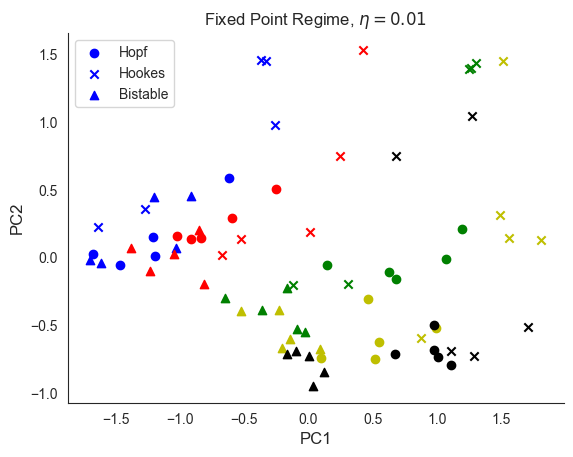

In [632]:
plt.title('Fixed Point Regime, $\eta = 0.01$')


plt.scatter(pca[:5,0], pca[:5,1], marker='o', c='b', label='Hopf')
plt.scatter(pca[5:10,0], pca[5:10,1], marker='o', c='r')
plt.scatter(pca[10:15,0], pca[10:15,1], marker='o', c='g')
plt.scatter(pca[15:20,0], pca[15:20,1], marker='o', c='y')
plt.scatter(pca[20:25,0], pca[20:25,1], marker='o', c='k')

plt.scatter(pca[25:30,0], pca[25:30,1], marker='x', c='b', label='Hookes')
plt.scatter(pca[30:35,0], pca[30:35,1], marker='x', c='r')
plt.scatter(pca[35:40,0], pca[35:40,1], marker='x', c='g')
plt.scatter(pca[40:45,0], pca[40:45,1], marker='x', c='y')
plt.scatter(pca[45:50,0], pca[45:50,1], marker='x', c='k')

plt.scatter(pca[50:55,0], pca[50:55,1], marker='^', c='b', label='Bistable')
plt.scatter(pca[55:60,0], pca[55:60,1], marker='^', c='r')
plt.scatter(pca[60:65,0], pca[60:65,1], marker='^', c='g')
plt.scatter(pca[65:70,0], pca[65:70,1], marker='^', c='y')
plt.scatter(pca[70:75,0], pca[70:75,1], marker='^', c='k')

plt.legend()
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('PC1', fontsize=12)
plt.ylabel('PC2', fontsize=12)
plt.show()

Uniform sampling over N, mu and eta for hopf system

In [764]:
def gen_hopf(num_samples): # num samples 
    # hopf 
    eta_val_hopf = np.random.uniform(0.001, 1, num_samples) 
    mu_val_hopf = np.random.uniform(-5, 5, num_samples) 
    N_val_hopf = np.random.uniform(50, 5000, num_samples) 
    lengths_store = list() 
    sols_list = list() 
    dt = 0.01 
    for i in range(num_samples): 
        length = ((N_val_hopf[i]+500)*dt)
        tspan = np.arange(0, length, dt) 
        mu = mu_val_hopf[i] 
        eta = eta_val_hopf[i] 
        def f(state, t): 
            x, y = state[0], state[1] 
            dxdt = -y + (mu - x**2 - y**2) * x 
            dydt = x + (mu - x **2 - y **2) * y 
            return dxdt, dydt 
        ic = np.array(np.random.uniform(size=2)) 
        gw = lambda y, t: eta * np.identity(ic.shape[0]) 
        fw = lambda y, t: np.array(f(y,t)) 
        sol = sdeint.itoint(fw, gw, np.array(ic), tspan) 
        lengths_store.append(len(sol[500:])) # store length of time series after burn in 
        sols_list.append(sol[500:]) 
    features_hopf = np.array([catch22.catch22_all(sols_list[i][:,0])['values'] for i in range(len(sols_list))]) 
    ts_hopf = sols_list # return list of 2 dim. time series 
    df_hopf = pd.DataFrame(features_hopf) 
    df_hopf['N'] = lengths_store 
    df_hopf['mu'] = mu_val_hopf 
    df_hopf['eta'] = eta_val_hopf 
    df_hopf['regime'] = 'Hopf' 
    return ts_hopf, df_hopf

In [777]:
np.random.seed(42)
ts_hopf, df_hopf = gen_hopf(1000)

In [778]:
rs = RobustScaler().fit(df_hopf.iloc[:,:22])
rs_fit = rs.transform(df_hopf.iloc[:,:22])
def sigmoid(x, theta):
    return 1/(1+np.exp(-theta*x))
sigmoid_transformer = FunctionTransformer(sigmoid, kw_args={'theta': 1.35})
sigmoid_transformer.fit(rs_fit)
sigmoid_fit = sigmoid_transformer.transform(rs_fit)
mm = MinMaxScaler().fit(sigmoid_fit)
X_hat = mm.transform(sigmoid_fit)

In [779]:
pca_fit = PCA(n_components=2).fit(X_hat)
pca = pca_fit.transform(X_hat)

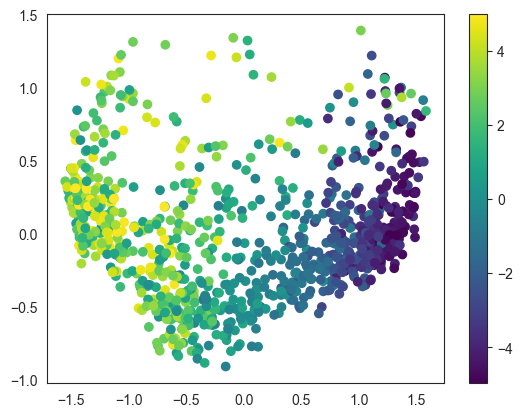

In [780]:
plt.scatter(pca[:,0], pca[:,1], c=df_hopf['mu'], cmap='viridis')
plt.colorbar()